# Contextual analysis

### Functions to upload, load and save files and models

In [1]:
import os

try:
  
  from google.colab import files
  import shutil
  import zipfile

  def get_file(name, upload=True):
    if not os.path.exists(name) and upload:
      uploaded = files.upload()
      map = uploaded.values()
      if len(map) == 0:
        return False
      data = list(map)[0]
      with open(name, 'wb') as f:
        f.write(data)
    return os.path.exists(name)

  def get_path(filename, folder='./'):
      return filename

  def save_model(model, name):
    directory = '{}/{}/'.format('models', name)
    archive = '{}.zip'.format(name)
    if not os.path.exists(directory):
      os.makedirs(directory)
    model.save(os.path.join(directory, name))
    shutil.make_archive(name, 'zip', directory)
    print(archive)
    files.download(archive)

  def load_model(name, upload=True):
    archive = '{}.zip'.format(name)
    if get_file(archive, upload) == False:
      return None
    zip_ref = zipfile.ZipFile(archive, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    lda = models.LdaModel.load(name)
    return lda
  
except ImportError:
  
    def get_file(name, upload=True):
        return os.path.exists(name)

    def get_path(filename, folder='data'):
        return os.path.join('../{}/'.format(folder), filename)

    def save_model(model, name):
        directory = '{}/{}/'.format('../data/models', name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        model.save(os.path.join(directory, name))

    def load_model(name, upload=True):
        directory = '{}/{}/'.format('../data/models', name)
        if os.path.exists(os.path.join(directory, name)):
            return models.LdaModel.load(os.path.join(directory, name))
        return None

### Load tweets from json file

In [2]:
import json

file = get_path("indexed_tweets.json")

get_file(file)

raw_data = json.load(open(file))
data = json.loads(raw_data)

In [3]:
import Preprocessing
import numpy as np

indexed_tweets = []
companies = []
id = 0
for company in data:
    name, language, tweet_list = company
    print(name)
    start = len(indexed_tweets)
    indexed_tweets += tweet_list
    originals_tweets = Preprocessing.execute("SELECT text FROM tweet WHERE searchterm = '@" + name + "'")
    companies.append((name, (start, len(indexed_tweets)), len(tweet_list), originals_tweets))
    id += 1

Adobe
airliquidegroup
Alstom
ArcelorMittal
Capgemini
Cisco
ENGIEgroup
Forrester
Generalelectric
Intel
MaerskLine
Oracle
orexad
orexad_FR
PublicisGroupe
Rexel_Group
SAFRAN
Salesforce
SolvayGroup
TechnipGroup
VMware
VolvoTrucksFR


In [4]:
indexed_tweets
tweets = list(map(lambda x: x[1], indexed_tweets))

### Generate a dictionary and a corpus of tweets (bag of words: (index, frequency))

In [5]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]
corpus[:2]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]

### Generate or load the lda (Latent Dirichlet allocation)

In [6]:
NB_TOPICS = 100
lda_filename = 'lda_model_noRT_{}'.format(NB_TOPICS)
lda = load_model(lda_filename)
if lda == None:
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NB_TOPICS)
    save_model(lda, lda_filename)
corpus_lda = lda[corpus]

### Expore topics generated by lda and see the more frequents words

In [7]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [94]:
 explore_topic(66, 50)

term                 frequency

looking              0.287
forward              0.151
product              0.149
soon                 0.068
said                 0.053
dx                   0.044
rest                 0.034
planning             0.033
ui                   0.027
exactly              0.019
evolution            0.016
sponsoring           0.014
poster               0.010
booked               0.008
band                 0.006
function             0.006
confirm              0.006
thick                0.005
founded              0.004
designers            0.004
evolved              0.001
disconnected         0.001
goddamn              0.000
crowdsourcing        0.000
gtm                  0.000
time                 0.000
1990s                0.000
design               0.000
new                  0.000
today                0.000
ux                   0.000
understandable       0.000
re                   0.000
deactivated          0.000
vray                 0.000
zawahiri             0.

### Graphical representation of topics

In [9]:
import pyLDAvis
import pyLDAvis.gensim

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

/Users/couver_v/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


### Generate a proper np array (companies, topics) from the lda array

In [9]:
import numpy as np
import sys

def lda_to_np(lda):
    array = np.zeros((len(lda), NB_TOPICS))
    for i, topics in enumerate(lda):
        if i % 100 == 0:
            sys.stdout.write('\r{} / {} => {}%'.format(i, len(lda), i / len(lda) * 100))
        k = 0
        for j in range(NB_TOPICS):
            if k < len(topics) and topics[k][0] == j:
                array[i][j] = topics[k][1]
                k += 1
    return array

npy_filename = get_path('lda_np_noRT_{}.npy'.format(NB_TOPICS))
if get_file(npy_filename):
    lda_np = np.load(npy_filename)
else:
    lda_np = lda_to_np(corpus_lda)
    np.save(npy_filename, lda_np)

### Generate an array to represente the % of activation of a topic for each company (companies, activation of topic)

In [10]:
def get_company_id(nb):
    for i, company in enumerate(companies):
        if company[1][1] > nb:
            return i

In [11]:
companies_topics = np.zeros((len(companies), NB_TOPICS))
threshold = 0.05

for i, tweet in enumerate(lda_np):
    for j, topic in enumerate(tweet):
        if topic > threshold:
            companies_topics[get_company_id(i)][j] += 1

activations_topics = [[companies_topics[i][j] / companies[i][2] * 100 for j in range(len(companies_topics[i]))] for i in range(len(companies_topics))]


/Users/couver_v/anaconda3/envs/b2b_emlyon/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


### Array of the mean activation of a topic for each company (companies, mean activation of topic)

In [12]:
def mean_topics(lda_np, companies):
  topics_by_company = []
  for company in companies:
    tweets = np.array(lda_np[company[1][0]:company[1][1]])
    company_topics = np.mean(tweets, 0)
    topics_by_company.append(company_topics)
  return np.array(topics_by_company)

companies_topics = mean_topics(lda_np, companies)

/Users/couver_v/anaconda3/envs/b2b_emlyon/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/couver_v/anaconda3/envs/b2b_emlyon/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


### Delete companies with NaN values or without non-zero value

In [13]:
def clear_companies(companies_topics, companies):
  clear_labels = []
  clear_topics = []
  for company, topics in zip(companies, companies_topics):
    if (not np.any(np.isnan(topics))) and np.any(topics):
      clear_labels.append(company[0])
      clear_topics.append(topics)
  return clear_labels, np.array(clear_topics)

clear_labels, clear_topics = clear_companies(companies_topics, companies)
_, clear_activations_topics = clear_companies(activations_topics, companies)

### Export companies by topic (csv)

In [96]:
import csv

selected_topics = [1, 3, 6, 11, 12, 13, 21, 22, 23, 24, 25, 26, 29, 30, 32, 33, 36, 39, 42, 45, 46, 47, 48, 49, 55, 58, 60, 62, 63, 70, 78, 80, 86, 87, 89, 94, 96, 97, 98, 99, 100]
topics_labels = list(map(lambda x: 'Topic {}'.format(x), selected_topics))

selected_topics = list(map(lambda x: x - 1, selected_topics))
topics_format = [list(map(lambda x: "n°{} - {:.2f}".format(x[1] + 1, x[0] * 1000000), zip(row, list(map(lambda x: x, [row[(-row).argsort()].tolist().index(i) for i in row]))))) for row in clear_topics.T[selected_topics]]
rows = np.concatenate([np.array(clear_labels)[:, None], np.array(topics_format).T], 1)

with open(get_path("companies_by_topic.csv", 'results'), 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow([""] + topics_labels)
    for row in rows:
        wr.writerow(row)

### "Normalize" topics

In [16]:
normalized_topics = [(topics - np.mean(topics)) / np.std(topics) for topics in clear_topics]
normalized_topics = np.array(normalized_topics)

normalized_activations_topics = [(topics - np.mean(topics)) / np.std(topics) for topics in clear_activations_topics]
normalized_activations_topics = np.array(normalized_activations_topics)

### Graphical representation of companies by topics on two dimensions (100 to 2 dimensions with t-SNE technique)

#### t-SNE mean

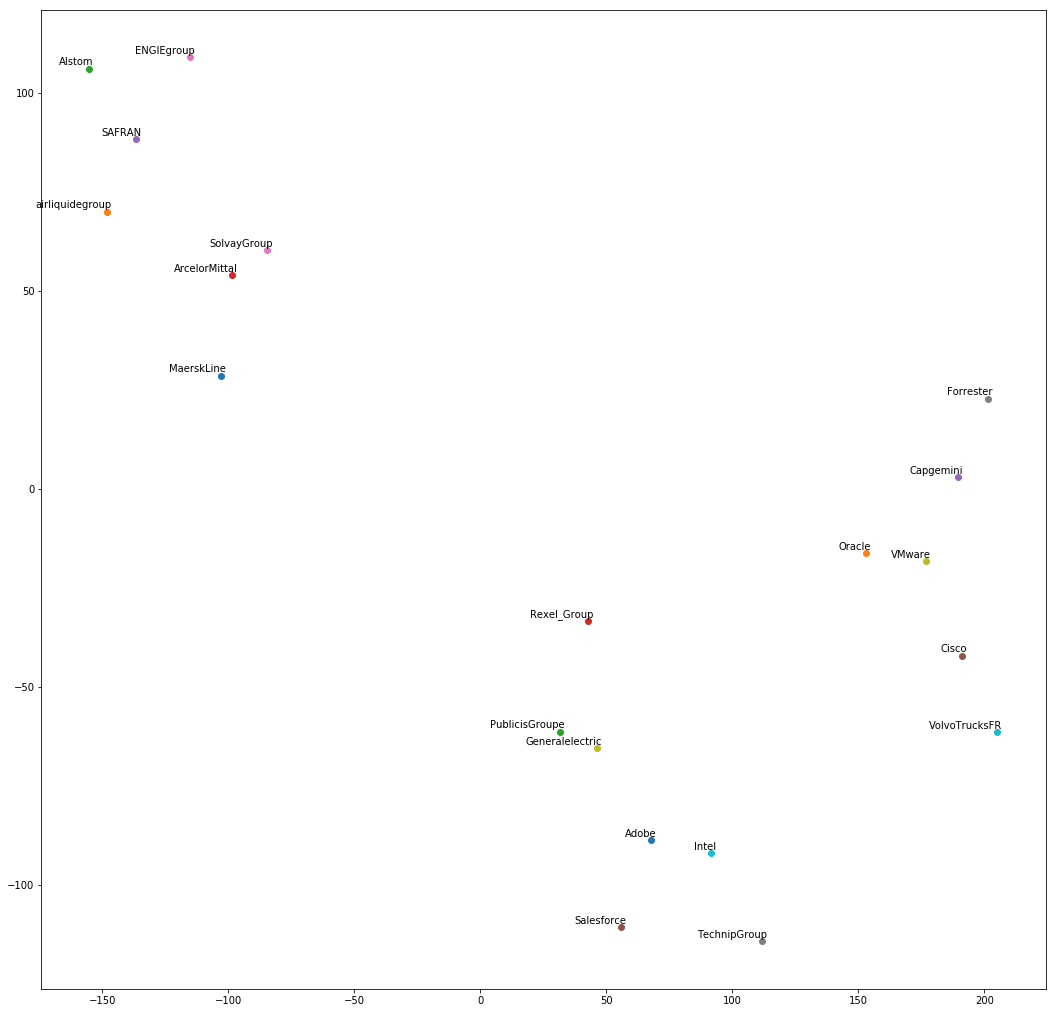

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename):
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.savefig(get_path(filename, 'results'))
  plt.show()

tsne = TSNE(perplexity=1, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(clear_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_mean.png')


#### t-SNE normalized mean

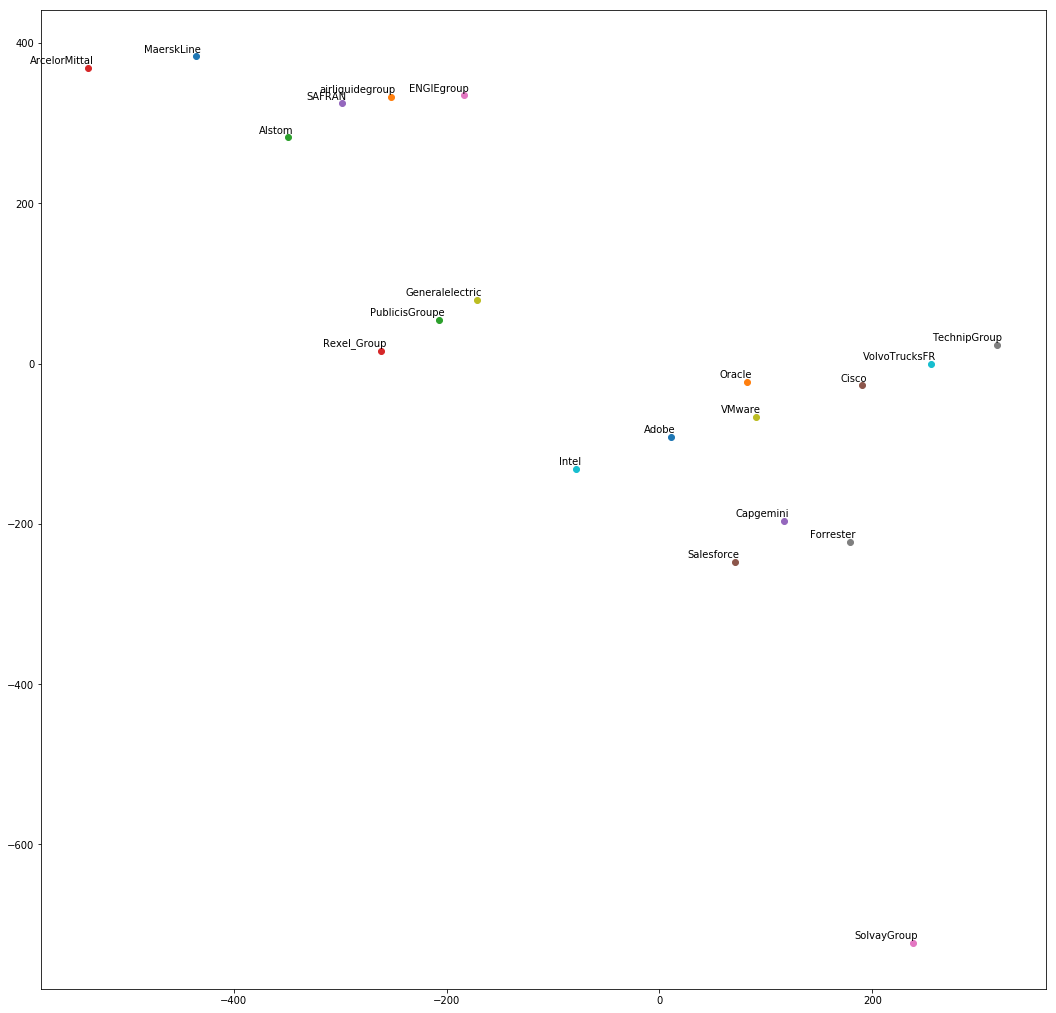

In [18]:
tsne = TSNE(perplexity=1, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(normalized_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_normalized_mean.png')

#### t-SNE activation

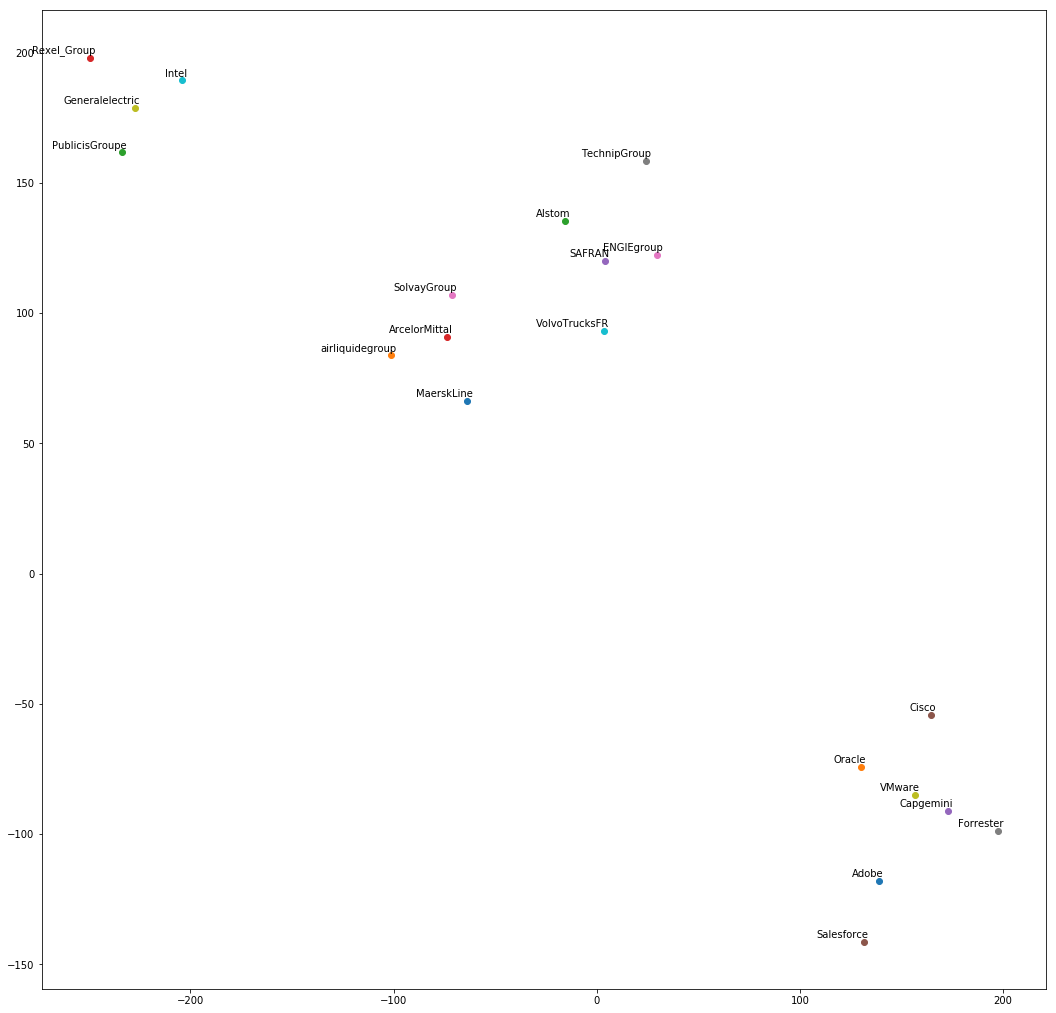

In [19]:
tsne = TSNE(perplexity=1, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(clear_activations_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_activation.png')

#### t-SNE normalized activation

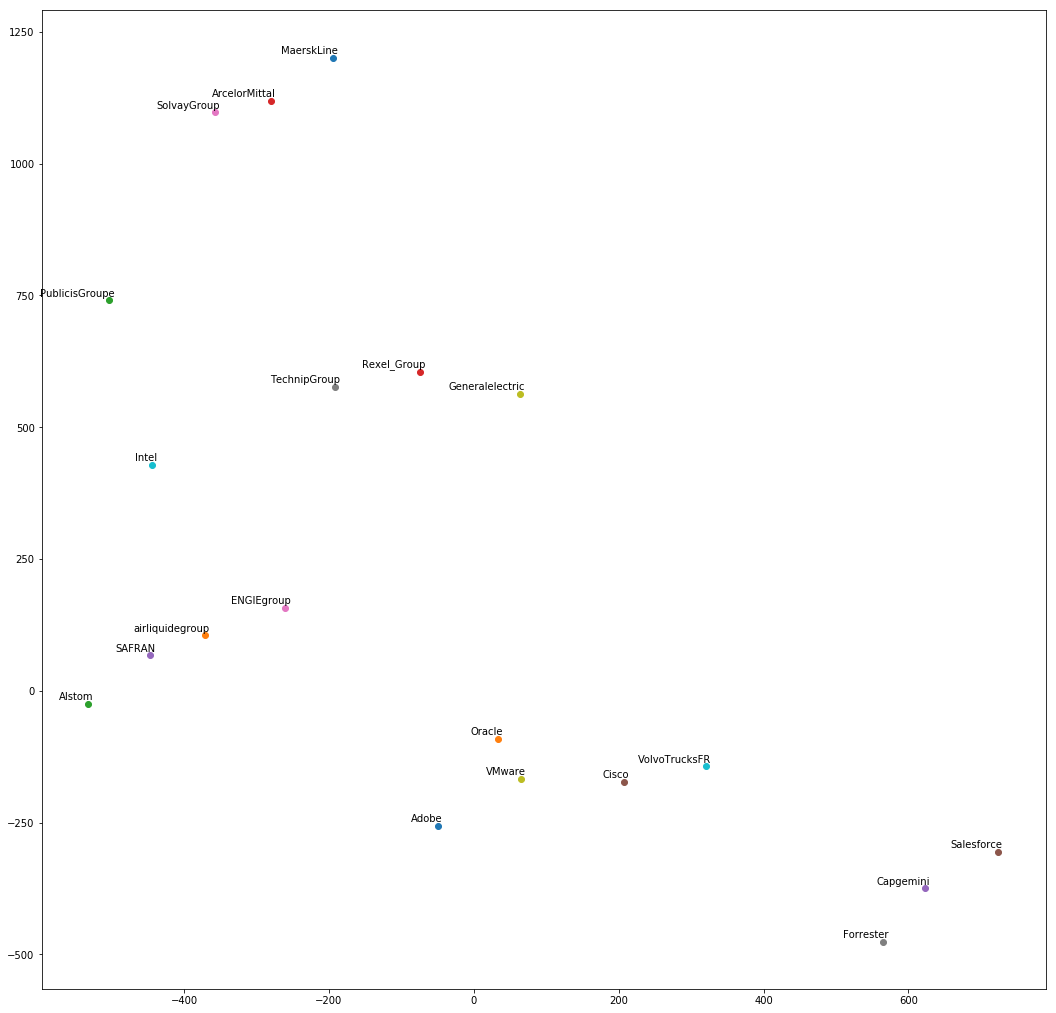

In [20]:
tsne = TSNE(perplexity=1, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(normalized_activations_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_normalized_activation.png')

### Graphical representation of companies by topics on two dimensions (only firsts two topics)

#### firsts topics mean

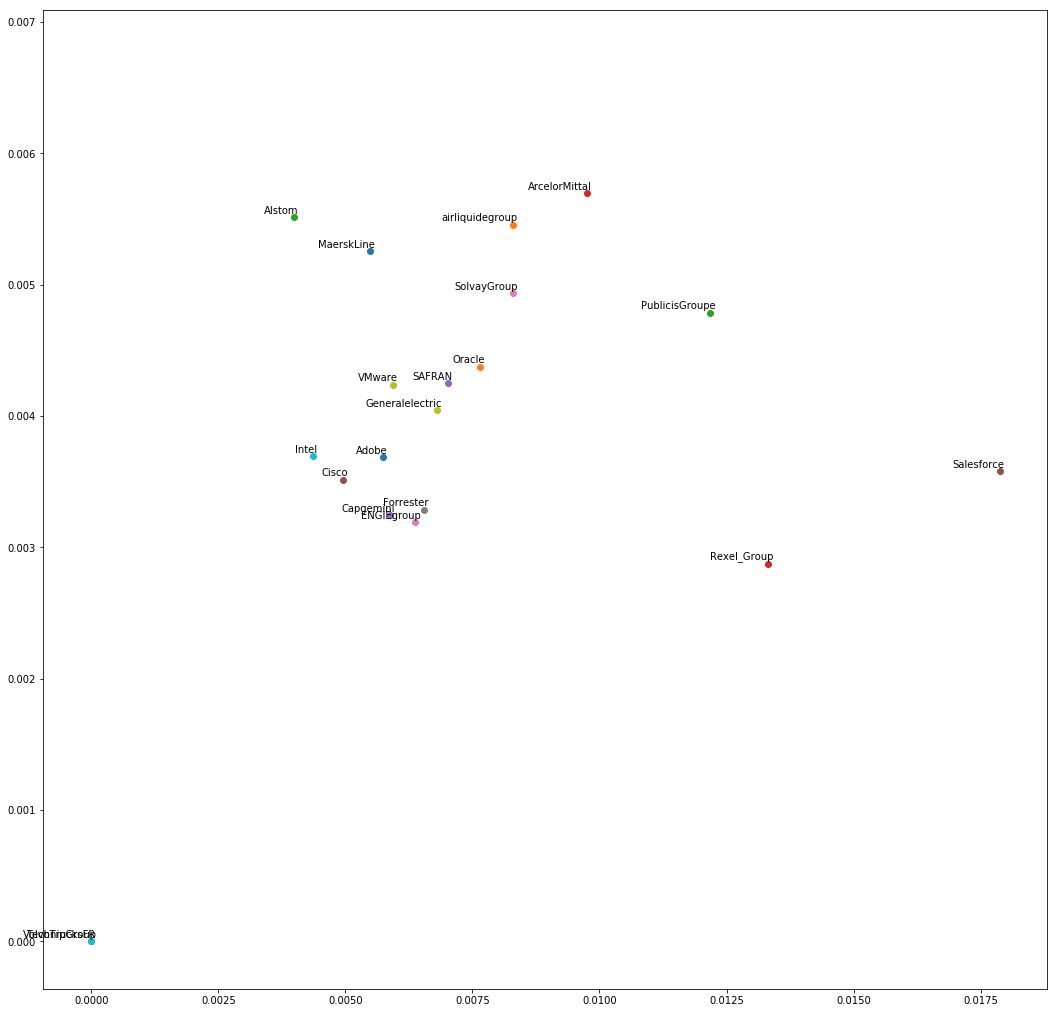

In [21]:
plot_with_labels(clear_topics[:, :2], clear_labels, 'firsts_topics_mean.png')

#### firsts topics normalized mean

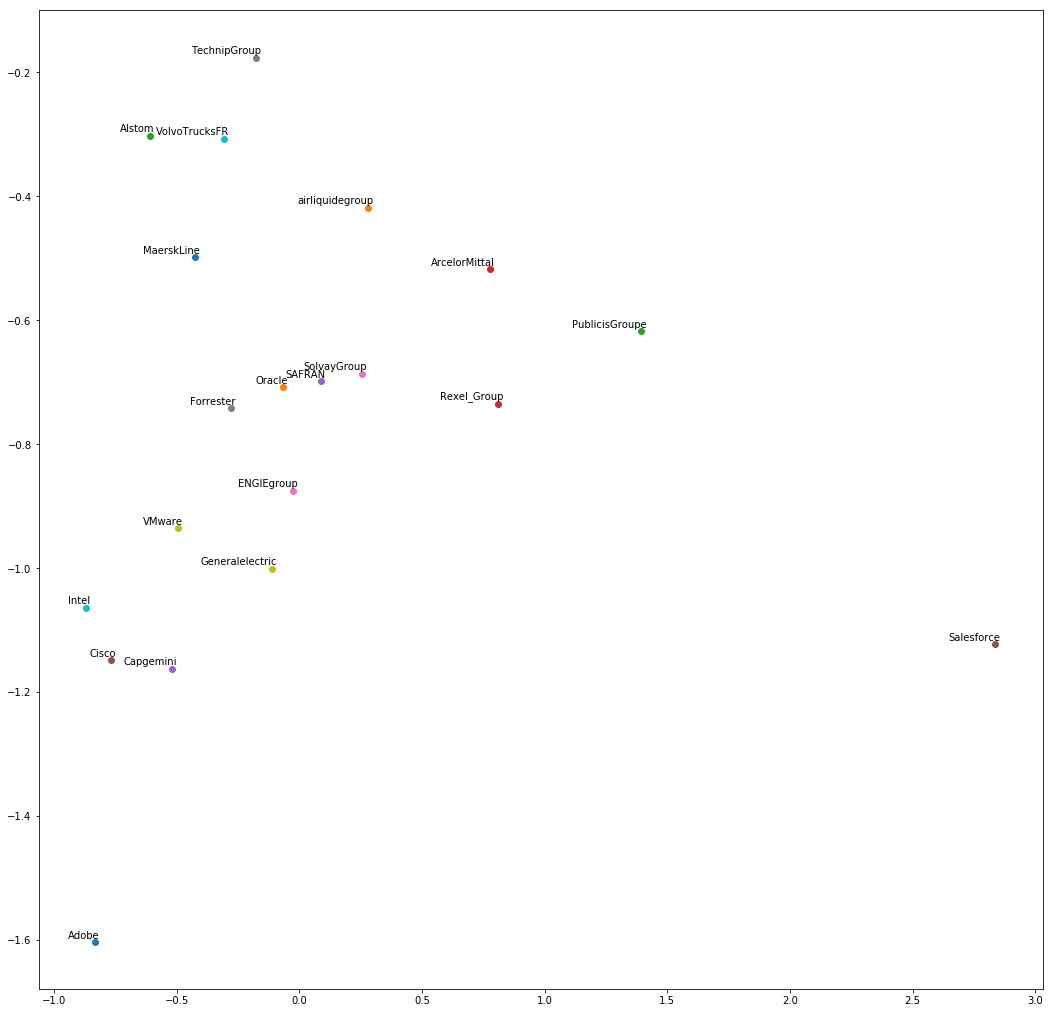

In [22]:
plot_with_labels(normalized_topics[:, :2], clear_labels, 'firsts_topics_normalized_mean.png')

#### firsts topics activation

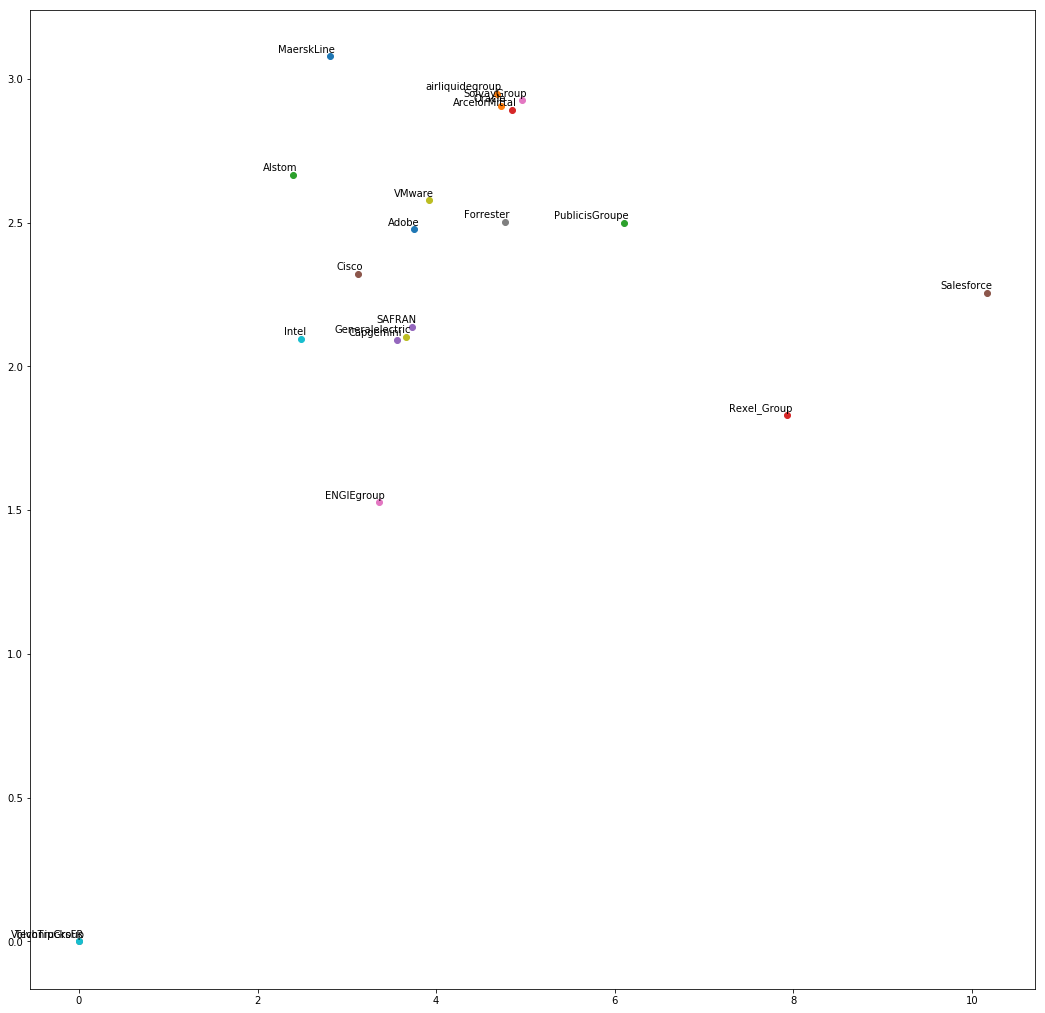

In [23]:
plot_with_labels(clear_activations_topics[:, :2], clear_labels, 'firsts_topics_activation.png')

#### firsts topics normalized activation

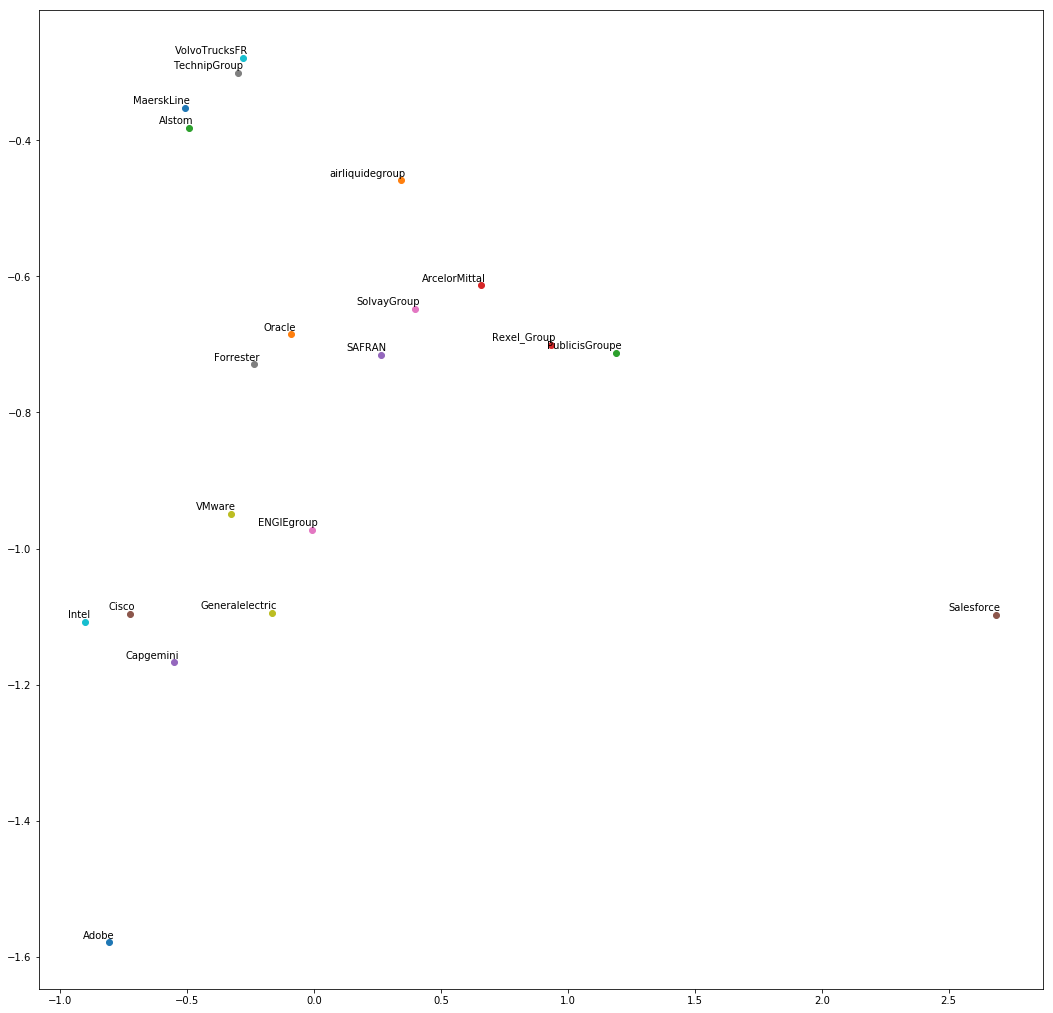

In [24]:
plot_with_labels(normalized_activations_topics[:, :2], clear_labels, 'firsts_topics_normalized_activation.png')

### Graphical representation of topics values by companies on three dimensions (to improve)

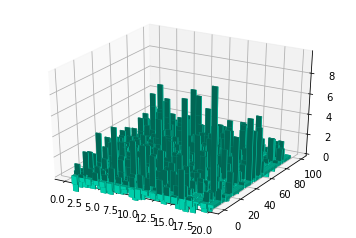

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
for i, topics in enumerate(normalized_topics):
    for j, topic in enumerate(topics):
        x.append(i)
        y.append(j)
        z.append(topic)

ax1.bar3d(x, y, 0, 0.75, 0.75, z, color='#00ceaa')
plt.show()
plt.savefig(get_path('3DBarChart-topicsByCompanies.png', 'results'))

Print the n tweets for a company most in connection with the topic

Company names

In [26]:
', '.join(clear_labels)

'Adobe, airliquidegroup, Alstom, ArcelorMittal, Capgemini, Cisco, ENGIEgroup, Forrester, Generalelectric, Intel, MaerskLine, Oracle, PublicisGroupe, Rexel_Group, SAFRAN, Salesforce, SolvayGroup, TechnipGroup, VMware, VolvoTrucksFR'

In [72]:
def company_by_name(name):
    for company in companies:
        if company[0] == name:
            return company
    raise Exception('No company for this name')

def tweets_by_topics_and_company(company_name, topic, n=0):
    company = company_by_name(company_name)
    indexes = np.array(list(map(lambda x: x[0], indexed_tweets[company[1][0]:company[1][1]])))
    company_topics = lda_np[company[1][0]:company[1][1]]
    sorted_indexes = indexes[np.flip(company_topics[:,topic].argsort(), 0)][:n]
    return np.array([company[3][i] for i in sorted_indexes])
  
print(tweets_by_topics_and_company(company_name='Adobe', topic=99, n=50))

[['@Adobe TY TY TY']
 ['@aundrelarrow @Adobe Yesssss!!! Congrats aundre!! ????????']
 ["@JohnAtkinPR @lee_jarvis @fpocha @morid1n @hsupengjun @stroughtonsmith @Adobe @MacAffinity @atpfm But that doesn't… https://t.co/sbsZDFJofb"]
 ['@joeDmarti @Adobe @Microsoft @iSocialFanz @danielnewmanUV @MackCollier @adamsconsulting @mowenranger @Ross_Quintana @MadalynSklar congrats!']
 ['Congrats @Mettlecom and @Adobe https://t.co/yLYnD2bkqz']
 ['@jkup @Adobe Woah! Congrats! ????']
 ['Congrats, @Adobe! https://t.co/0GxEmVLTOs']
 ['@aundrelarrow @Adobe woah! Congrats, homie!']
 ['@aembury @Adobe Congrats! ????????']
 ['@amazon @Apple @AlibabaGroup @Adobe @Aurora_MMJ A+ Companies']
 ['@coryedwards @FortuneMagazine Congrats @Adobe!!! ????????']
 ['@Adobe Mistakenly #Leaks Upcoming #PhotoEditing Software On #CreativeCloud ???? https://t.co/FljGjgxP5T… https://t.co/hPa3QV3uEh']
 ['@LittleDevilcom @Adobe All of the software &amp; hardware variations are not as straightforward as the 2 or 3 variation… htt